## Library

In [542]:
# core libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling / preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# metrics & utils
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from scipy.stats import skew

# imbalanced-learn (jika dipakai)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


## Load Data

In [ ]:
# Load dataset
df = pd.read_csv("heart_disease_uci.csv")

# Pilih kolom penelitian
columns_used = ["sex", "cp", "trestbps", "fbs","ca", "num"] #ca ga usah
df = df[columns_used]

# ==========================
# Target → biner
# ==========================
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

# Ganti nilai 0 pada trestbps jadi NaN (agar bisa diimputasi)
df["trestbps"] = df["trestbps"].replace(0, np.nan)

df
print(df.info())
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       920 non-null    object 
 1   cp        920 non-null    object 
 2   trestbps  860 non-null    float64
 3   fbs       830 non-null    object 
 4   num       920 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 36.1+ KB
None
      sex               cp  trestbps    fbs  num
0    Male   typical angina     145.0   True    0
1    Male     asymptomatic     160.0  False    1
2    Male     asymptomatic     120.0  False    1
3    Male      non-anginal     130.0  False    0
4  Female  atypical angina     130.0  False    0


Dalam dataset tersebut memiliki label, yang dimana biasa disebut sebagai supervised learning.

## Exploratory Data Analysis

1. Cek info dataset

In [544]:
# Menampilkan informasi ringkas datase
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       920 non-null    object 
 1   cp        920 non-null    object 
 2   trestbps  860 non-null    float64
 3   fbs       830 non-null    object 
 4   num       920 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 36.1+ KB


In [545]:
# Tampilkan statistik deskriptif dataset
df.describe()

,trestbps,num
count,860.000000,920.000000
mean,132.286047,0.553261
std,18.536175,0.497426
min,80.000000,0.000000
25%,120.000000,0.000000
50%,130.000000,1.000000
75%,140.000000,1.000000
max,200.000000,1.000000


2. Cek missing values

In [546]:
# cek missing values dan nol
missing_values = df.isnull().sum()
zero_values = (df == 0).sum()

print("Jumlah missing values:")
print(missing_values)
print("\nJumlah nol:")
print(zero_values)

Jumlah missing values:
sex          0
cp           0
trestbps    60
fbs         90
num          0
dtype: int64

Jumlah nol:
sex           0
cp            0
trestbps      0
fbs         692
num         411
dtype: int64


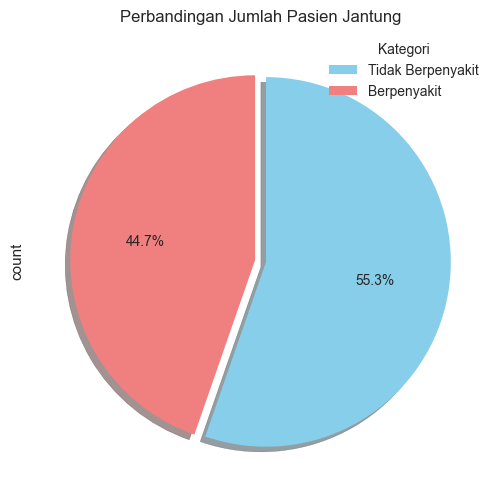

In [563]:
# Distribusi target
plt.figure(figsize=(6,6))
df["num"].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=["skyblue", "lightcoral"],
    labels=None,
    explode=(0.03, 0.03),
    shadow=True
)
plt.title("Perbandingan Jumlah Pasien Jantung")
plt.legend(labels=["Tidak Berpenyakit", "Berpenyakit"], title="Kategori", loc="best")
plt.show()

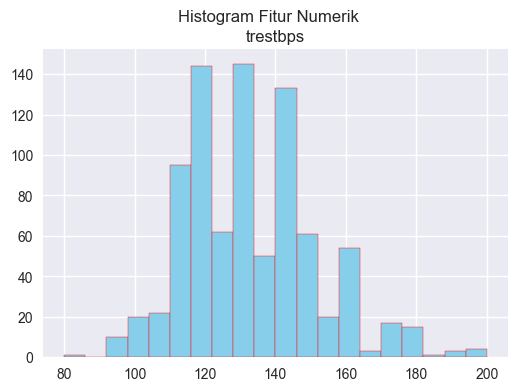

In [548]:
# Histogram numerik
df[["trestbps"]].hist(figsize=(6,4), bins=20, color='skyblue', edgecolor='red')
plt.suptitle("Histogram Fitur Numerik")
plt.show()

3. outlier


untuk variabel seperti trestbps (resting blood pressure), alasan tidak langsung dihapus outlier-nya:

Outlier bisa mencerminkan kondisi medis yang nyata.
Tekanan darah sangat tinggi atau rendah memang jarang, tapi bisa terjadi pada pasien dengan risiko penyakit jantung. Jadi kalau dihapus, justru bisa menghilangkan informasi penting.

Konteks klinis lebih penting daripada aturan statistik.
Misalnya, orang dengan tekanan darah 200 mmHg dianggap "ekstrem" secara statistik, tapi itu bisa menggambarkan hipertensi parah → relevan dalam penelitian penyakit jantung.

Dataset UCI Heart Disease memang klinis.
Artinya, data diambil dari pasien rumah sakit. Outlier di sini lebih ke rare case (kasus jarang), bukan error.

Risiko bias jika dihapus.
Kalau dibuang, model bisa jadi hanya belajar dari pasien "normal", padahal tujuan riset adalah mendeteksi yang berisiko tinggi.

In [549]:
# Outlier check
num_cols = ["trestbps"]
outlier_summary = {}
for col in num_cols:
    col_skew = skew(df[col].dropna())
    if -1 < col_skew < 1:  # normal → Z-score
        mean = df[col].mean()
        std = df[col].std()
        z_scores = (df[col] - mean) / std
        outliers = df[np.abs(z_scores) > 3]
        method = "Z-Score"
    else:  # skewed → IQR
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        method = "IQR"
    outlier_summary[col] = {
        "Skewness": round(col_skew, 2),
        "Metode": method,
        "Jumlah Outlier": outliers.shape[0]
    }
print(pd.DataFrame(outlier_summary).T)

         Skewness   Metode Jumlah Outlier
trestbps     0.63  Z-Score              7


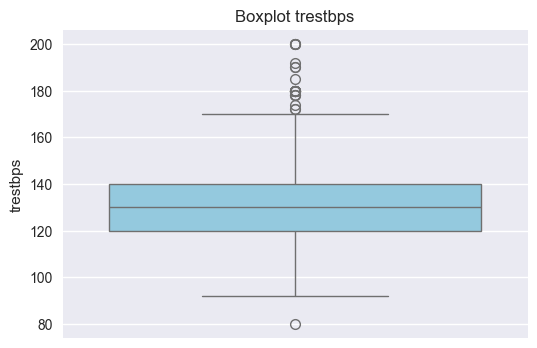

In [550]:
# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(y=df["trestbps"], color="skyblue")
plt.title("Boxplot trestbps")
plt.show()

## Data Preprocessing

In [551]:
# pisahkan fitur dan target
X = df.drop("num", axis=1)   # fitur
y = df["num"]                # target

In [552]:
# split train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [553]:
# 4. Preprocessing Pipeline
categorical_cols = ["sex", "cp", "fbs"]
numeric_cols = ["trestbps"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
        ]), categorical_cols)
    ]
)

## Modelling

Perbedaan penting:

Logistic Regression → butuh scaling (sudah otomatis di pipeline numeric transformer).

Random Forest → tidak perlu scaling, tapi karena kita pakai pipeline yang sama, data tetap diimputasi + encoded + scaled → aman (meskipun scaling tidak berpengaruh).

In [554]:
## Model Pipelines
logmodel = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

## Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, metrics_dict, probs_dict):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    metrics_dict[model_name] = {
        "accuracy": acc,
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"]
    }
    probs_dict[model_name] = (y_test, y_prob)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negatif", "Positif"],
                yticklabels=["Negatif", "Positif"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## Training & Evaluation

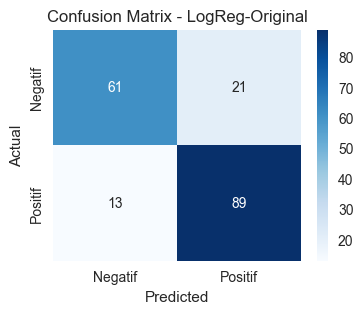

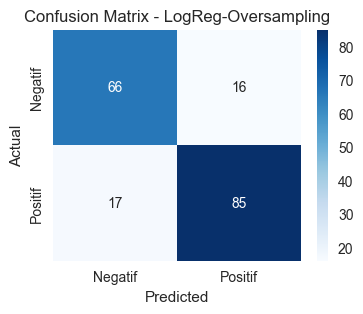

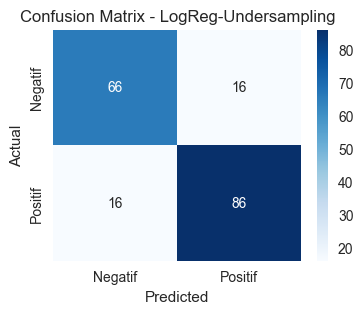

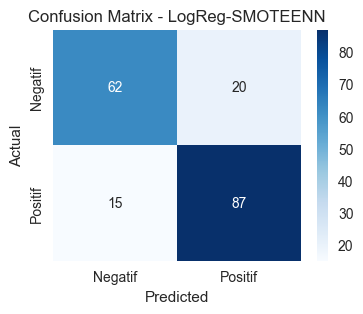

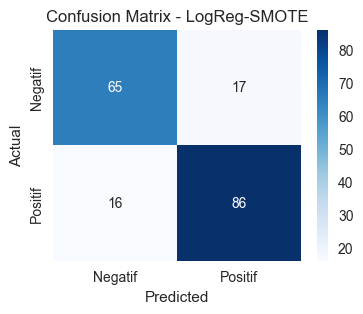

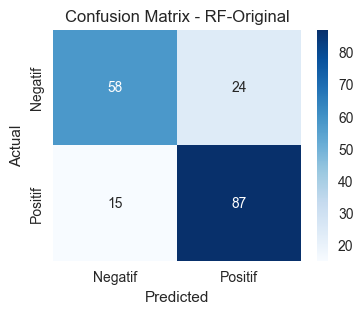

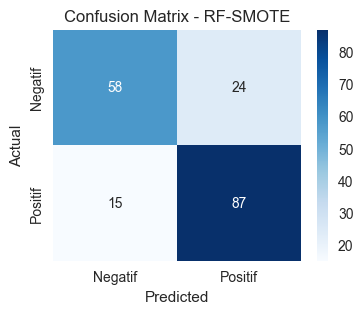

In [555]:
# === Helper: Preprocessing ke array numeric ===

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

## Training & Evaluation
metrics = {}
probs = {}

# Logistic Regression (original)
evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_prep, y_train, X_test_prep, y_test,
    "LogReg-Original", metrics, probs
)

# Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_prep, y_train)
evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_ros, y_ros, X_test_prep, y_test,
    "LogReg-Oversampling", metrics, probs
)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_prep, y_train)
evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_rus, y_rus, X_test_prep, y_test,
    "LogReg-Undersampling", metrics, probs
)

# SMOTEENN
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X_train_prep, y_train)
evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_sme, y_sme, X_test_prep, y_test,
    "LogReg-SMOTEENN", metrics, probs
)

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_prep, y_train)
evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_smote, y_smote, X_test_prep, y_test,
    "LogReg-SMOTE", metrics, probs
)

# Random Forest (original)
evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_prep, y_train, X_test_prep, y_test,
    "RF-Original", metrics, probs
)

# Random Forest (SMOTE)
evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_smote, y_smote, X_test_prep, y_test,
    "RF-SMOTE", metrics, probs
)


## Perbandingan Metrik

                      accuracy  precision    recall        f1
LogReg-Original       0.815217   0.809091  0.872549  0.839623
LogReg-Oversampling   0.820652   0.841584  0.833333  0.837438
LogReg-Undersampling  0.826087   0.843137  0.843137  0.843137
LogReg-SMOTEENN       0.809783   0.813084  0.852941  0.832536
LogReg-SMOTE          0.820652   0.834951  0.843137  0.839024
RF-Original           0.788043   0.783784  0.852941  0.816901
RF-SMOTE              0.788043   0.783784  0.852941  0.816901


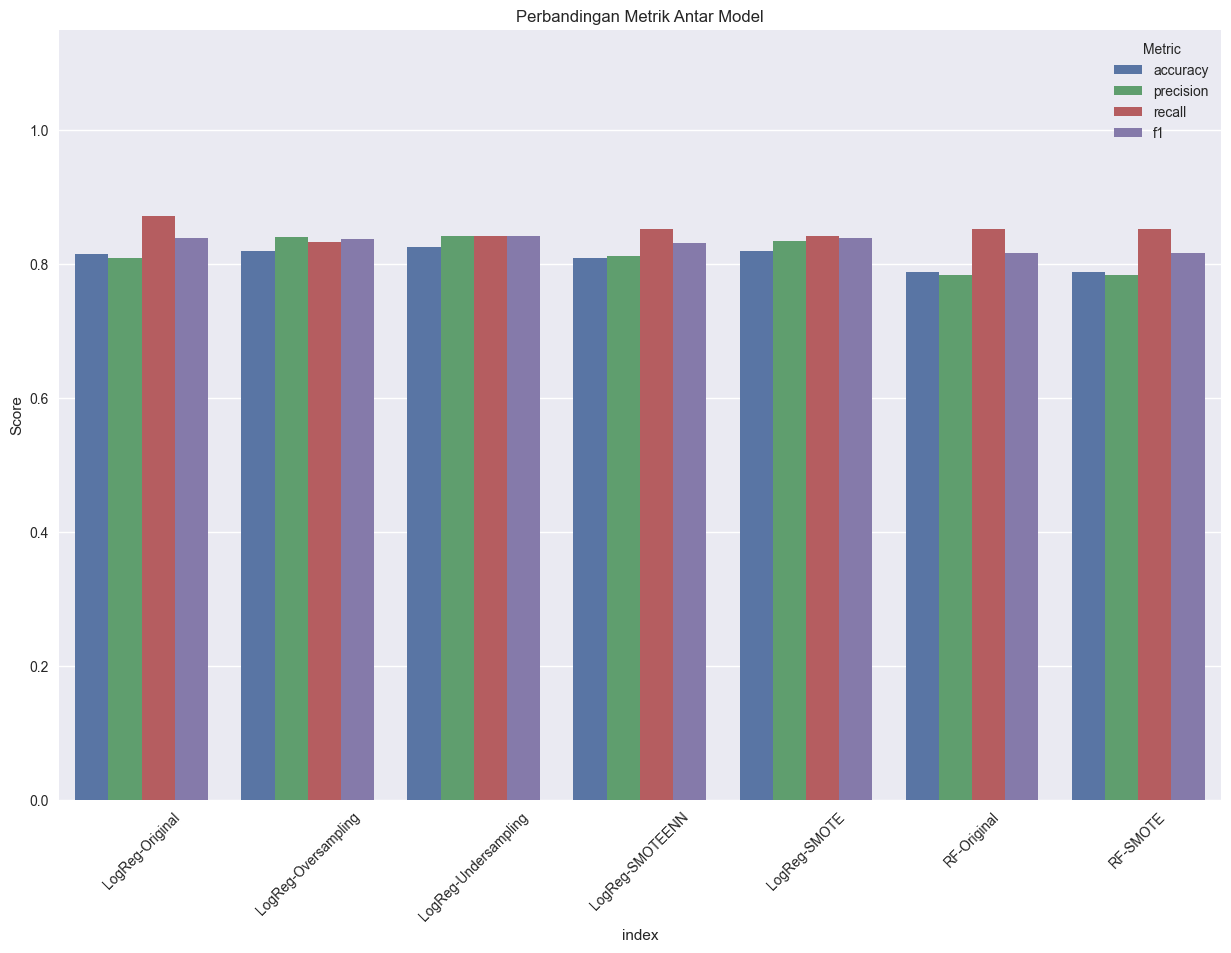

In [556]:
## Perbandingan Metrik
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

plt.figure(figsize=(15,10))
sns.barplot(data=metrics_df.reset_index().melt(id_vars="index"),
            x="index", y="value", hue="variable")
plt.title("Perbandingan Metrik Antar Model")
plt.ylabel("Score")
plt.ylim(0,1.15)
plt.xticks(rotation=45)
plt.legend(title="Metric", loc="upper right")
plt.show()

## ROC Curve

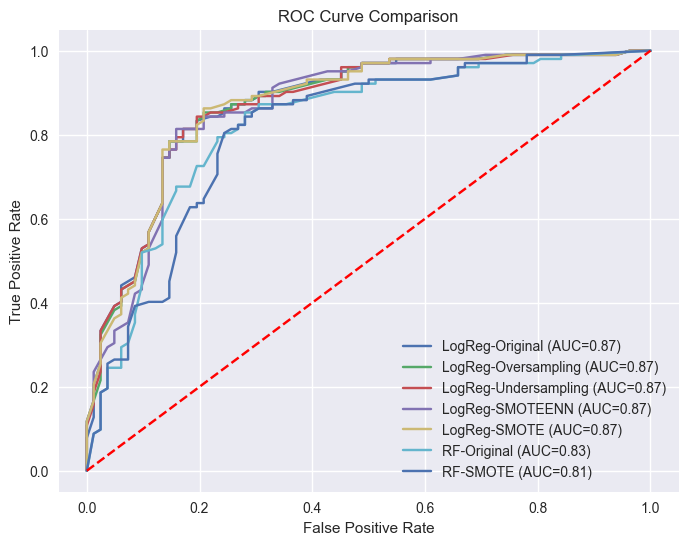

In [557]:
## ROC Curve
plt.figure(figsize=(8,6))
for model_name, (y_true, y_prob) in probs.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

In [560]:
df

,sex,cp,trestbps,fbs,num
0,Male,typical angina,145.0,True,0
1,Male,asymptomatic,160.0,False,1
2,Male,asymptomatic,120.0,False,1
3,Male,non-anginal,130.0,False,0
4,Female,atypical angina,130.0,False,0
...,...,...,...,...,...
915,Female,asymptomatic,127.0,True,1
916,Male,typical angina,NaN,False,0
917,Male,asymptomatic,122.0,True,1
918,Male,asymptomatic,NaN,True,0
